In [1]:
# imports
from copy import deepcopy
import numpy as np
from statistics import mean

import sys
sys.path.append('../src/')

from classification import get_stumps
from evaluation import central_train_accuracy, central_test_accuracy, edges, central_loss
from network import synthetic_graph, get_alphas
from related_works import colearning, lafond_FW
from optimization import regularized_local_FW, local_FW, global_regularized_local_FW, gd_reg_local_FW, centralized_FW
from utils import generate_models, generate_moons, get_min_max

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# set graph of nodes with local personalized data
NB_ITER = 2000
K = 20
D = 20
n = 200
NOISE_R = 0.05
random_state = 2017
MU = 1
BETA = 10

V, theta_true, _, angles = generate_models(nb_clust=2, inter_clust_stdev=1, nodes_per_clust=K // 2, random_state=random_state, get_angles=True)
_, X, Y, X_test, Y_test, max_nb_instances = generate_moons(V, theta_true, D, random_state=random_state, sample_error_rate=NOISE_R)

# set graph
nodes, adj_matrix, similarities = synthetic_graph(X, Y, X_test, Y_test, V, theta_true, max_nb_instances)

# set monitors for optimization analysis
monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
    'loss': [central_loss, []],
}

# get weak classifiers
vmin, vmax = get_min_max(X)
base_clfs = get_stumps(n=n, d=D+1, min_v=vmin, max_v=vmax)

results = {}

colors = {
    "Dada": "b",
    "global l1 Adaboost": "g",
    "purely local models": "k",
    "global-local mixture": "y",
    "personalized linear": "m",    
}

In [3]:
nodes_copy = deepcopy(nodes)
results["Dada"] = regularized_local_FW(nodes_copy, base_clfs, beta=BETA, nb_iter=NB_ITER, mu=MU, monitors=monitors, checkevery=20)

In [4]:
centralized_nodes = deepcopy(nodes)
centralized_FW(centralized_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["global l1 Adaboost"] = {}
results["global l1 Adaboost"]["train-accuracy"] = central_train_accuracy(centralized_nodes)
results["global l1 Adaboost"]["test-accuracy"] = central_test_accuracy(centralized_nodes)

local_nodes = deepcopy(nodes)
local_FW(local_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["purely local models"] = {}
results["purely local models"]["train-accuracy"] = central_train_accuracy(local_nodes)
results["purely local models"]["test-accuracy"] = central_test_accuracy(local_nodes)

global_nodes = deepcopy(nodes)
global_regularized_local_FW(global_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["global-local mixture"] = {}
results["global-local mixture"]["train-accuracy"] = central_train_accuracy(global_nodes)
results["global-local mixture"]["test-accuracy"] = central_test_accuracy(global_nodes)

results["personalized linear"], clf_colearning = colearning(K, X, Y, X_test, Y_test, D, NB_ITER, adj_matrix, similarities, mu=MU, max_samples_per_node=max_nb_instances)

# Accuracy and Convergence

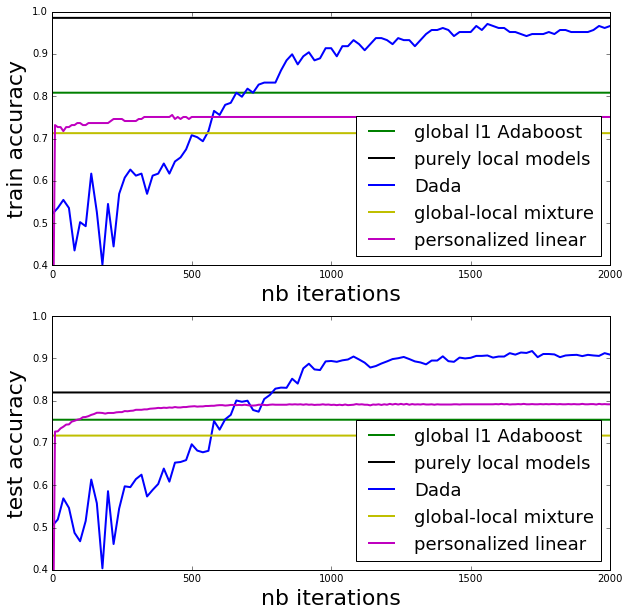

In [5]:
plt.figure(1, figsize=(10, 10))

max_iter = 2000
plt.subplot(211)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('train accuracy', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0.4, 1)

for k, r_list in results.items():
    try:
        if k == "Dada":
            c = 20
        else:
            c = 10
        plt.plot([i*c for i in range(len(r_list))], [r['train-accuracy'] for r in r_list], label='{}'.format(k), color=colors[k], linewidth=2)
    except:
        plt.plot(range(NB_ITER+1), [r_list['train-accuracy']]*(NB_ITER+1), label='{}'.format(k), color=colors[k], linewidth=2)

plt.legend(loc='lower right', fontsize=18)

plt.subplot(212)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0.4, 1)

for k, r_list in results.items():
    try:
        if k == "Dada":
            c = 20
        else:
            c = 10
        plt.plot([i*c for i in range(len(r_list))], [r['test-accuracy'] for r in r_list], label='{}'.format(k), color=colors[k], linewidth=2)
    except:
        plt.plot(range(NB_ITER+1), [r_list['test-accuracy']]*(NB_ITER+1), label='{}'.format(k), color=colors[k], linewidth=2)

plt.legend(loc='lower right', fontsize=18)

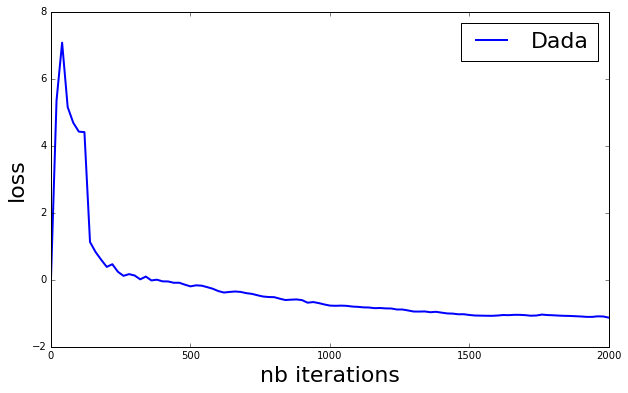

In [6]:
# convergence

max_iter = 4000
plt.figure(1, figsize=(10, 6))

plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('loss', fontsize=22)

for k, r_list in results.items():
    try:
        plt.plot([i*20 for i in range(len(r_list))], [r['loss'] for r in r_list], label='{}'.format(k), color=colors[k], linewidth=2)
    except:
        pass

plt.legend(loc='upper right', fontsize=22)

# Communication

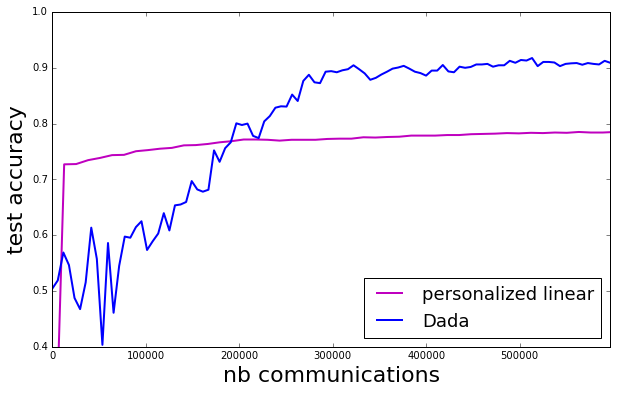

In [7]:
from math import log

Z = 32
# test accuracy vs communication
linear_com = 2*D*Z
regularized_com = np.sum(adj_matrix)/K *(Z + log(n))

x_linear = [linear_com*i*10 for i in range(len(results['personalized linear']))]
x_regularized = [regularized_com*i*20 for i in range(len(results['Dada']))]

plt.figure(1, figsize=(10, 6))

plt.xlabel('nb communications', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)

plt.plot(x_linear, [r['test-accuracy'] for r in results['personalized linear']], label='personalized linear', color=colors['personalized linear'], linewidth=2)
plt.plot(x_regularized, [r['test-accuracy'] for r in results['Dada']], label='Dada', color=colors['Dada'], linewidth=2)

plt.xlim(0, min(max(x_regularized), max(x_linear)))
plt.ylim(0.4, 1)
plt.legend(loc="lower right", fontsize=18)

# Graph Discovery

### study impact of alpha and beta hyperparameters learning W

In [8]:
from optimization import graph_discovery, kalo_graph_discovery

# set monitors for optimization analysis
monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
    'edges': [edges, []]
}

MU = 1
# graph discovery
gd_pace = 200
results_gd = {}

results_gd["ground-truth graph"] = results["Dada"]
results_gd["purely local models"] = results["purely local models"]


q = 4
init_w = graph_discovery(local_nodes, q)
gd_nodes = deepcopy(local_nodes)
results_gd["uniform graph"] = gd_reg_local_FW(gd_nodes, base_clfs, init_w, gd_method={"name":"uniform", 
        "pace_gd": gd_pace, "args":(q, )}, beta=BETA, mu=MU, reset_step=False, nb_iter=NB_ITER, monitors=monitors, checkevery=20)

b = 0.1
init_w = kalo_graph_discovery(local_nodes, MU, b)
gd_nodes = deepcopy(local_nodes)
results_gd["kalo graph"] = gd_reg_local_FW(gd_nodes, base_clfs, init_w, gd_method={"name":"kalo", 
    "pace_gd": gd_pace, "args":(MU, b)}, beta=BETA, mu=MU, reset_step=False, nb_iter=NB_ITER, monitors=monitors, checkevery=20)

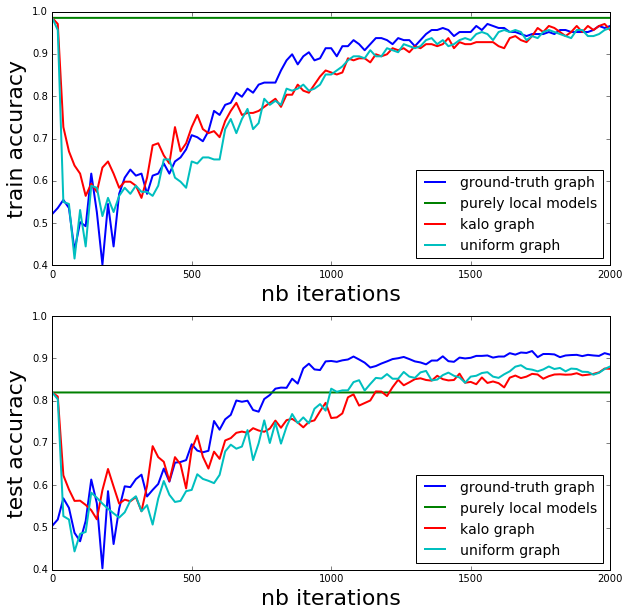

In [9]:
max_iter = NB_ITER

plt.figure(1, figsize=(10, 10))

plt.subplot(211)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('train accuracy', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0.4, 1)

for k, r_list in results_gd.items():
    try:
        plt.plot([i*20 for i in range(len(r_list))], [r['train-accuracy'] for r in r_list], label='{}'.format(k), linewidth=2)
    except:
        plt.plot(range(NB_ITER+1), [r_list['train-accuracy']]*(NB_ITER+1), label='{}'.format(k), linewidth=2)
        
plt.legend(loc='lower right', fontsize=14)

plt.subplot(212)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0.4, 1)

for k, r_list in results_gd.items():
    try:
        plt.plot([i*20 for i in range(len(r_list))], [r['test-accuracy'] for r in r_list], label='{}'.format(k), linewidth=2)
    except:
        plt.plot(range(NB_ITER+1), [r_list['test-accuracy']]*(NB_ITER+1), label='{}'.format(k), linewidth=2)

plt.legend(loc='lower right', fontsize=14)



kalo graph 7.4
uniform graph 4.0


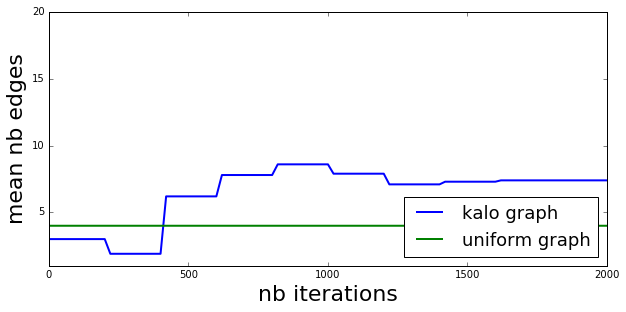

In [10]:
max_iter = 2000
NB_ITER = 2000
plt.figure(1, figsize=(10, 10))

plt.subplot(211)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('mean nb edges', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(1, 20)

for k, r_list in results_gd.items():
    try:
        print(k, np.mean(r_list[-1]['edges']))
        plt.plot([i*20 for i in range(len(r_list))], [np.mean(r['edges']) for r in r_list], label='{}'.format(k), linewidth=2)
    except:
        pass

plt.legend(loc='lower right', fontsize=18)

## Graph correlations

In [12]:
from scipy.stats import spearmanr

matrix_angles = np.empty((K, K))
for i in range(K):
    for j in range(K):
        matrix_angles[i, j] = abs(angles[i] - angles[j])

print("Correlation with angles")
print("kalo", spearmanr(matrix_angles, results_gd["kalo graph"][-1]["similarities"], axis=None))
print("uniform", spearmanr(matrix_angles, results_gd["uniform graph"][-1]["similarities"], axis=None))

print("\nCorrelation with similarities")
print("kalo", spearmanr(similarities, results_gd["kalo graph"][-1]["similarities"], axis=None))
print("uniform", spearmanr(similarities, results_gd["uniform graph"][-1]["similarities"], axis=None))

# print(matrix_angles)
print(np.sum(matrix_angles.T == matrix_angles) == K**2)

Correlation with angles
kalo SpearmanrResult(correlation=-0.56620725916700687, pvalue=2.7583535136946347e-35)
uniform SpearmanrResult(correlation=-0.2430150532544024, pvalue=8.6977178283359428e-07)

Correlation with similarities
kalo SpearmanrResult(correlation=0.69865383900913725, pvalue=7.6080170475163119e-60)
uniform SpearmanrResult(correlation=0.32603935370063281, pvalue=2.3268103139753297e-11)
True


In [13]:
import networkx as nx

STEP = gd_pace
kalo_graph = nx.from_numpy_matrix(results_gd["kalo graph"][-1]["adj-matrix"])
uniform_graph = nx.from_numpy_matrix(results_gd["uniform graph"][-1]["adj-matrix"])
groundtruth_graph = nx.from_numpy_matrix(adj_matrix)

pos = nx.spring_layout(groundtruth_graph)

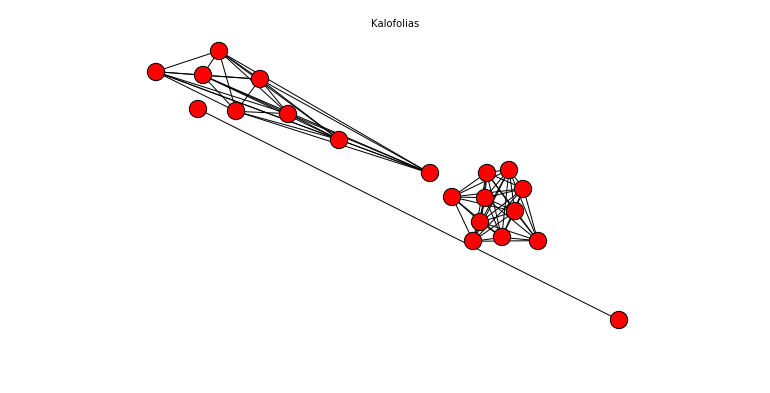

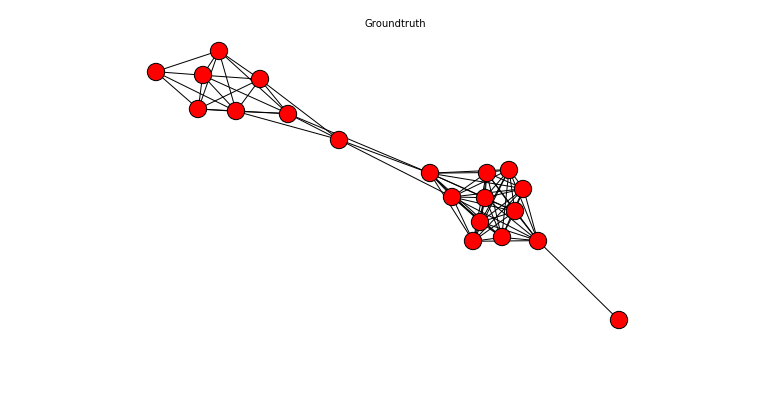

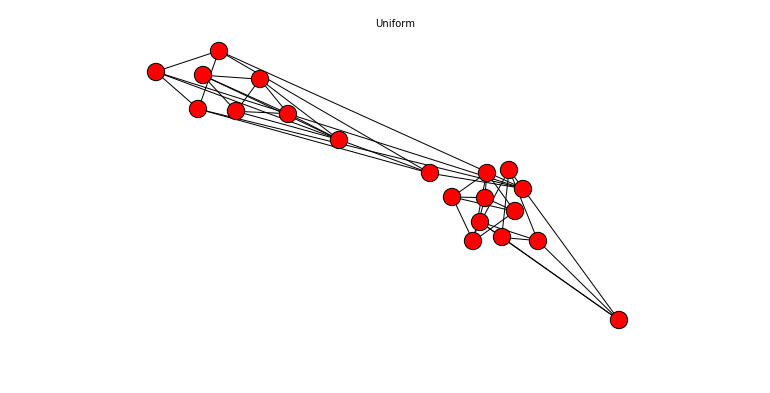

In [14]:
plt.figure(1, figsize=(10, 5))
plt.suptitle('Kalofolias')
nx.draw(kalo_graph, pos)

plt.figure(2, figsize=(10, 5))
plt.suptitle('Groundtruth')
nx.draw(groundtruth_graph, pos)

plt.figure(3, figsize=(10, 5))
plt.suptitle('Uniform')
nx.draw(uniform_graph, pos)

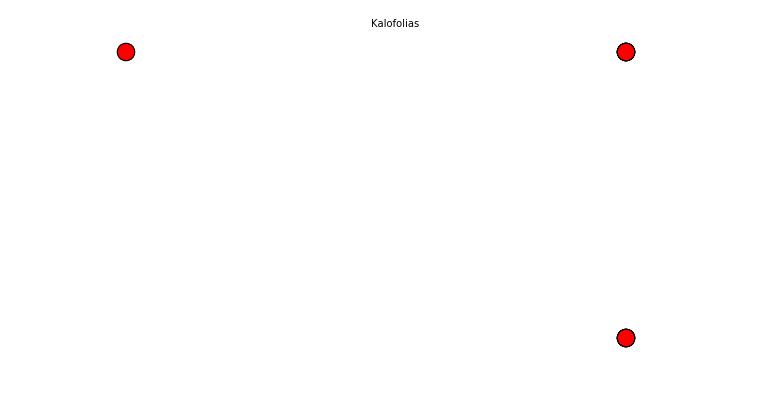

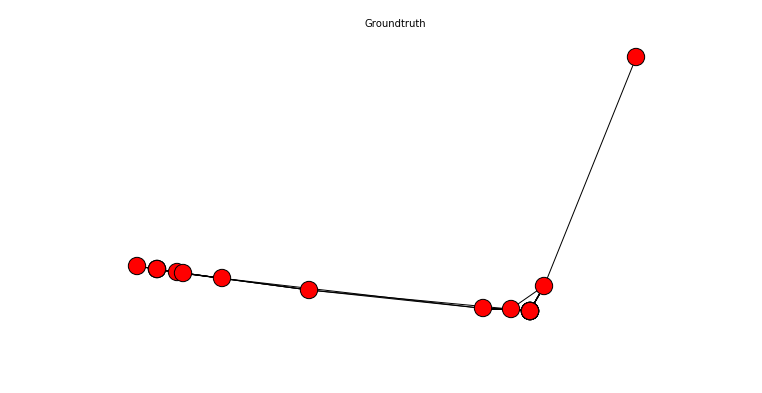

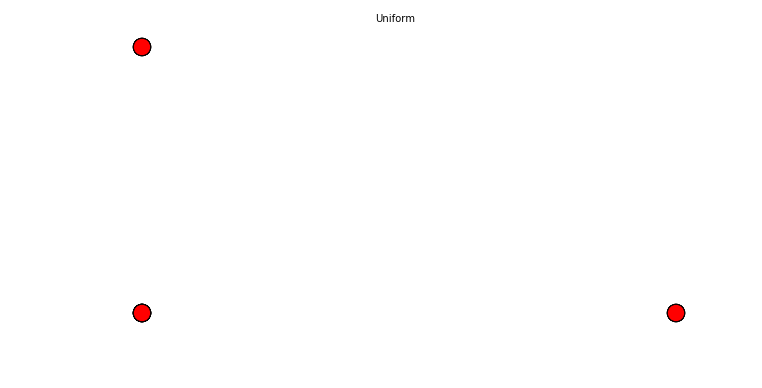

In [15]:
# communities
plt.figure(1, figsize=(10, 5))
plt.suptitle('Kalofolias')
nx.draw_spectral(kalo_graph)

plt.figure(2, figsize=(10, 5))
plt.suptitle('Groundtruth')
nx.draw_spectral(groundtruth_graph)

plt.figure(3, figsize=(10, 5))
plt.suptitle('Uniform')
nx.draw_spectral(uniform_graph)

## Accuracy vs sparsity


In [16]:
results_kalo = {}

gd_pace = 200
for mu in [1]:
    for b in [10**i for i in range(-4, 5)]:
        print(mu, b)
        init_w = kalo_graph_discovery(local_nodes, mu, b)
        gd_nodes = deepcopy(local_nodes)
        gd_reg_local_FW(gd_nodes, base_clfs, init_w, gd_method={"name":"kalo", "pace_gd": gd_pace, "args":(mu, b)},
                        beta=BETA, mu=mu, reset_step=False, nb_iter=NB_ITER, monitors={}, checkevery=20)
        results_kalo["(mu, b) = ({}, {})".format(mu, b)] = {}
        results_kalo["(mu, b) = ({}, {})".format(mu, b)]["train-accuracy"] = central_train_accuracy(gd_nodes)
        results_kalo["(mu, b) = ({}, {})".format(mu, b)]["test-accuracy"] = central_test_accuracy(gd_nodes)        
        results_kalo["(mu, b) = ({}, {})".format(mu, b)]["mean-edges"] = np.mean(edges(gd_nodes))

1 0.0001
1 0.001
1 0.01
1 0.1
1 1
1 10
1

../src/optimization.py:79: RuntimeWarning: divide by zero encountered in true_divide
  grad = mu * z / 2 - (1. / d).dot(S) + 2 * b * w
../src/optimization.py:81: RuntimeWarning: invalid value encountered in less
  w[w < 0] = 0
../src/kalofolias.py:52: RuntimeWarning: invalid value encountered in less
  if np.any(w < 0):
../src/utils.py:482: RuntimeWarning: invalid value encountered in greater
  adjacency = similarities > thresh


 100
1 1000
1 10000


In [17]:
# sort reaults
train = {}
test = {}
for k, value in results_kalo.items():
    try:
        train[value["mean-edges"]].append(value["train-accuracy"])
    except:
        train[value["mean-edges"]] = [value["train-accuracy"]]
    
    try:
        test[value["mean-edges"]].append(value["test-accuracy"])
    except:
        test[value["mean-edges"]] = [value["test-accuracy"]]

train_sorted_keys = sorted(train.keys())    
test_sorted_keys = sorted(test.keys())    

{1.5: [0.96650717703349287], 19.0: [0.8995215311004785, 0.9138755980861244, 0.9138755980861244, 0.8995215311004785], 1.7: [0.9569377990430622], 6.7999999999999998: [0.93779904306220097], 1.8999999999999999: [0.92822966507177029], 13.800000000000001: [0.90909090909090906]}


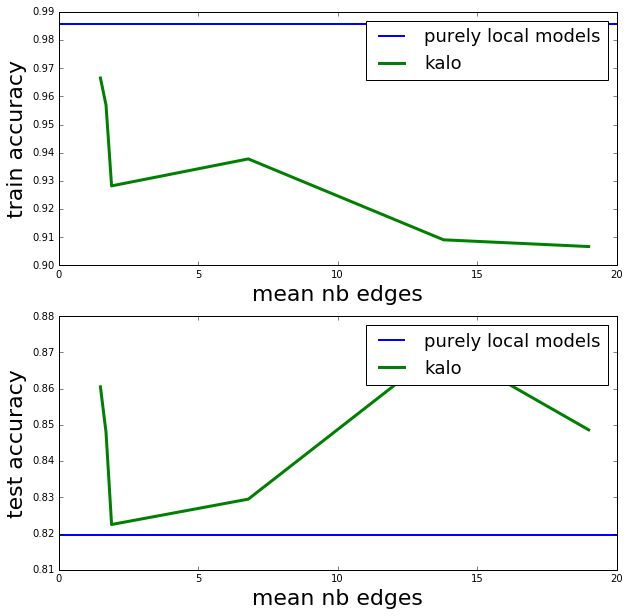

In [18]:
plt.figure(1, figsize=(10, 10))

print(train)
plt.subplot(211)
plt.xlabel('mean nb edges', fontsize=22)
plt.ylabel('train accuracy', fontsize=22)
plt.xlim(0, 20)
# plt.ylim(0.5, 1.1)

plt.plot(range(21), [results['purely local models']['train-accuracy']]*21, label='purely local models', linewidth=2)
plt.plot(train_sorted_keys, [np.mean(train[k]) for k in train_sorted_keys], label='kalo', linewidth=3)
# plt.scatter([value[] for k, value in results_kalo.items()], [], linewidth=1)

plt.legend(loc='upper right', fontsize=18)

plt.subplot(212)
plt.xlabel('mean nb edges', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)
plt.xlim(0, 20)
# plt.ylim(0.5, 1.1)

plt.plot(range(21), [results['purely local models']['test-accuracy']]*21, label='purely local models', linewidth=2)
plt.plot(test_sorted_keys, [np.mean(test[k]) for k in test_sorted_keys], label='kalo', linewidth=3)

plt.legend(loc='upper right', fontsize=18)